# Imports

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.preprocessing import MinMaxScaler

# Dataset

## Obtaining the dataset

In [51]:
# getting the dataset from the csv file
data = pd.read_csv('Lab6-Proj1_Dataset.csv')

In [48]:
data.tail()

,Anchor_Ratio,Transmission_Range,Node_Density,Step_Size,Iterations,ESLE
280,0.15,18.40,0.01,1.0,6,2.420293
281,0.15,18.40,0.01,1.2,6,2.427482
282,0.18,26.45,0.01,0.9,6,1.690174
283,0.18,26.45,0.01,1.0,6,1.707076
284,0.18,26.45,0.01,1.2,6,1.712146


### Statistical Analysis of the dataset  

In [23]:
# shape
print(data.shape)

# quick statistical analysis of the dataset
data.describe()

(285, 6)


,Anchor_Ratio,Transmission_Range,Node_Density,Step_Size,Iterations,ESLE
count,285.000000,285.000000,285.000000,285.000000,285.000000,2.850000e+02
mean,0.207474,20.554737,0.015158,1.033333,37.536842,1.220366e+00
std,0.065472,3.410259,0.006796,0.124941,24.104881,1.536450e+00
min,0.140000,17.250000,0.010000,0.900000,6.000000,8.900000e-08
25%,0.150000,17.250000,0.010000,0.900000,20.000000,7.837210e-01
50%,0.180000,20.700000,0.010000,1.000000,30.000000,1.054853e+00
75%,0.300000,23.000000,0.020000,1.200000,60.000000,1.360695e+00
max,0.300000,28.750000,0.030000,1.200000,90.000000,2.500000e+01


General Boxplot

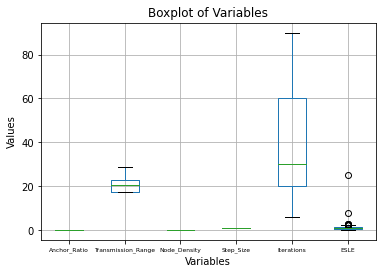

In [24]:
# generating the boxplot
data.boxplot()

# setting the plot title and axes labels
plt.title('Boxplot of Variables')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.xticks(fontsize=6)

# displaying the plot
plt.show()

Individual Boxplots for better visualization

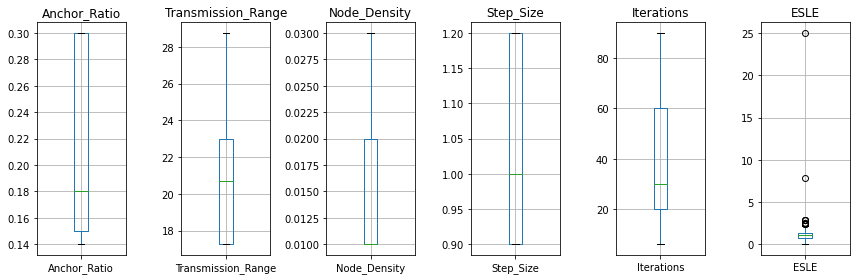

In [25]:
# Determine the number of variables
num_variables = len(data.columns)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=num_variables, figsize=(12, 4))

# Generate individual boxplots for each variable
for i, column in enumerate(data.columns):
    data.boxplot(column=column, ax=axes[i])
    axes[i].set_title(column)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

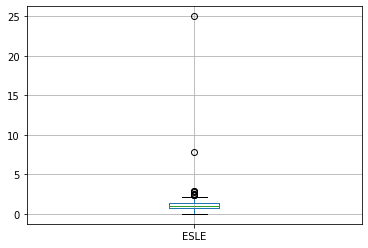

<Figure size 1080x720 with 0 Axes>

In [27]:
data.boxplot(column='ESLE')

# Display the plot
plt.figure(figsize=(15, 10))
plt.show()

Checking histograms (maybe we'll fit them to a close distribution)

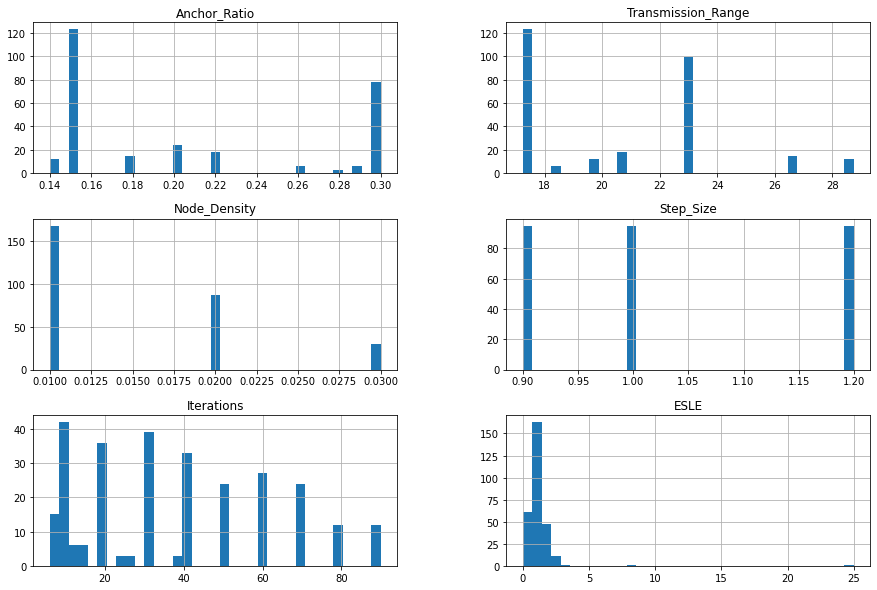

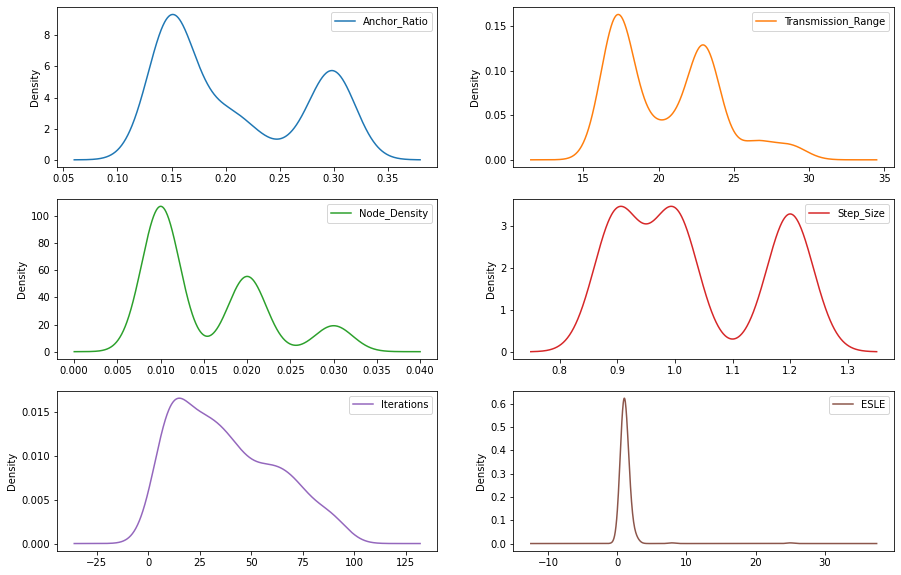

In [28]:
# Histogram of the dataset
data.hist(figsize=(15, 10), bins=data.shape[0]//8)
plt.show()

# density plot of the dataset
data.plot(kind='density', subplots=True, layout=(3,2), sharex=False, figsize=(15, 10))
plt.show()

In [9]:
from fitter import Fitter, get_common_distributions, get_distributions


# Create a dictionary to store the fitted distributions
fitted_distributions = {}

# Iterate over each feature
for feature in data.columns:
    # Extract the data for the current feature
    
    feature_data = data[feature].values
    
    # Create an instance of the Fitter class for the current feature
    f = Fitter(feature_data) #,distributions=get_common_distributions()
    
    # Fit the distributions for the current feature
    f.fit()
    
    # Store the fitted distributions in the dictionary
    fitted_distributions[feature] = f


Fitting 110 distributions:  32%|███▏      | 35/110 [00:05<00:10,  7.19it/s]/home/gustavo/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:3485: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t1 = integrate.quad(llc, -np.inf, x)[0]
Fitting 110 distributions:  97%|█████████▋| 107/110 [00:23<00:03,  1.09s/it]/home/gustavo/anaconda3/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 distr

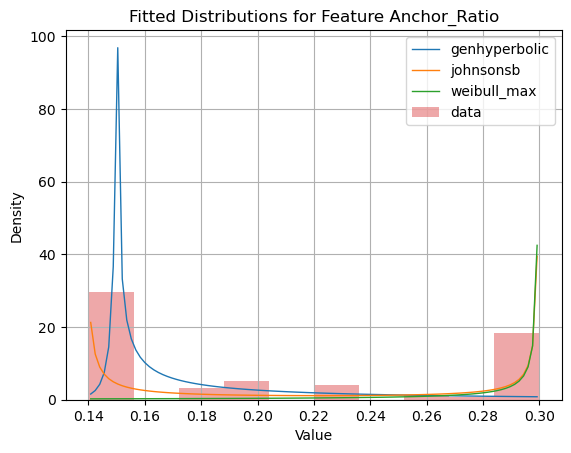

/home/gustavo/anaconda3/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


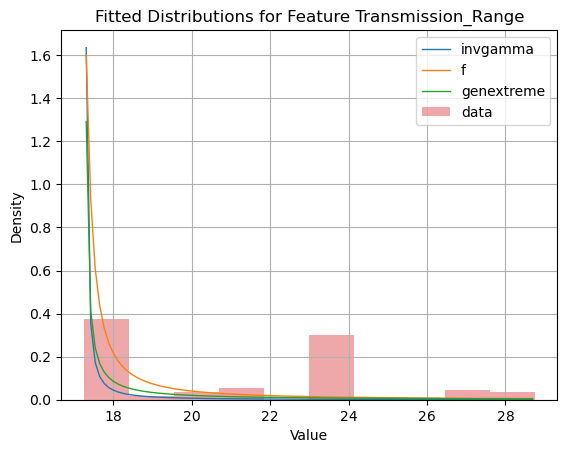

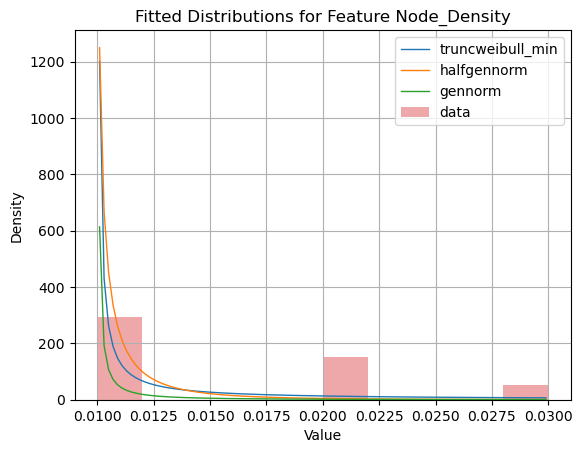

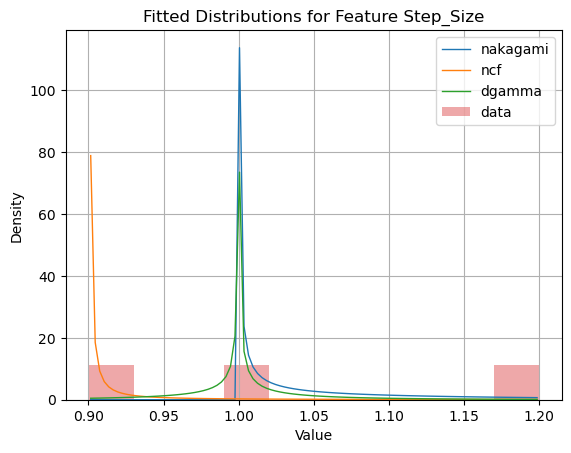

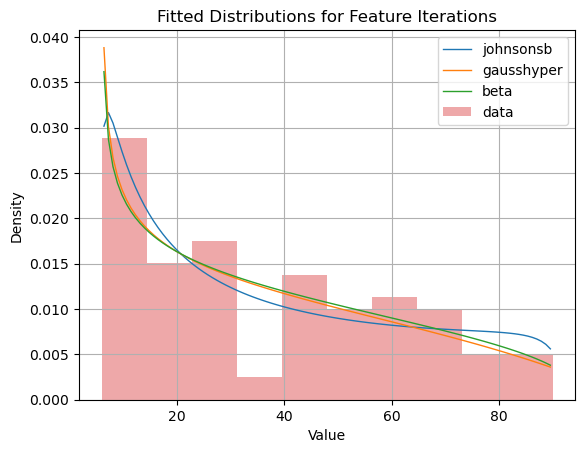

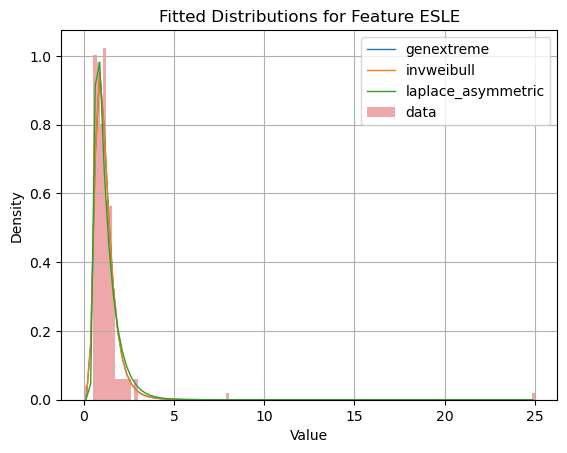

In [10]:
# Plotting the fitted distributions to the data
def plot_distributions(selected_feature, how_many_dist=3):
    fitted_dist = fitted_distributions[selected_feature]
    
    # Plot the fitted distributions
    fitted_dist.plot_pdf(Nbest=how_many_dist, lw=1)
    
    # Plot the histogram of the data
    plt.hist(data[selected_feature], bins='auto', density=True, alpha=0.4, label='data')
    
    # Set the plot title and axes labels
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Fitted Distributions for Feature {}'.format(selected_feature))
    
    # Display the legend
    plt.legend()
    
    # Display the plot
    plt.show()



for feature in data.columns:
    plot_distributions(feature, 3)

## Data Preprocessing 

### Data Cleaning

- No incomplete data
- Is there noisy data? (no indication for errors, nor outlier, but might there be outliers?)
- No inconsistent data
- Is there intentional data? (certainly doesn't seem like so)

In [54]:
# Verify if there are any missing values
print(data.isnull().sum())

# Boxplot: ends of the box are the quartiles; median is marked; add
# whiskers, and plot outliers individually
# 1.5 x IQR rule
# Calculate the IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1


# get data only with iterations column value < 20
data_outliers = data[data['Iterations'] < 20]

# Get observations with above or qual to 1.5 x IQR rule 
data_outliers = ((data_outliers < (Q1 - 1.5 * IQR)) | (data_outliers > (Q3 + 1.5 * IQR))) 

# Print observations with above or qual to 1.5 x IQR rule 
outliers_to_visualize = data_outliers[data_outliers.any(axis=1)]

# Remove observations in the outliers_to_visualize from the data
data_wout_outliers = data.drop(outliers_to_visualize.index, axis=0)


Anchor_Ratio          0
Transmission_Range    0
Node_Density          0
Step_Size             0
Iterations            0
ESLE                  0
dtype: int64


c:\Users\leo_b\anaconda3\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\leo_b\anaconda3\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


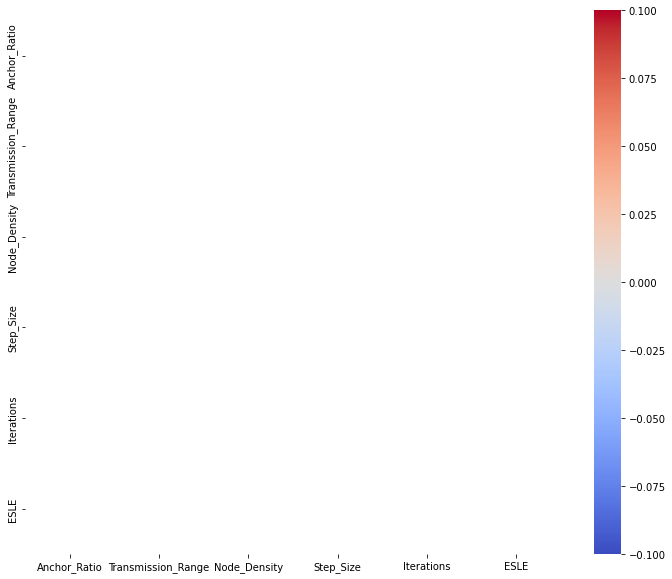

In [56]:

# Calculate correlation matrix for your outliers
corr_matrix = outliers_to_visualize.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Data Integration

- combine data from different sources. are there different sources? (don't think so)
- any different scale / unit problems? (better check)
- any redudant features? (correlation analysis, covariance analysis) (should delve further)

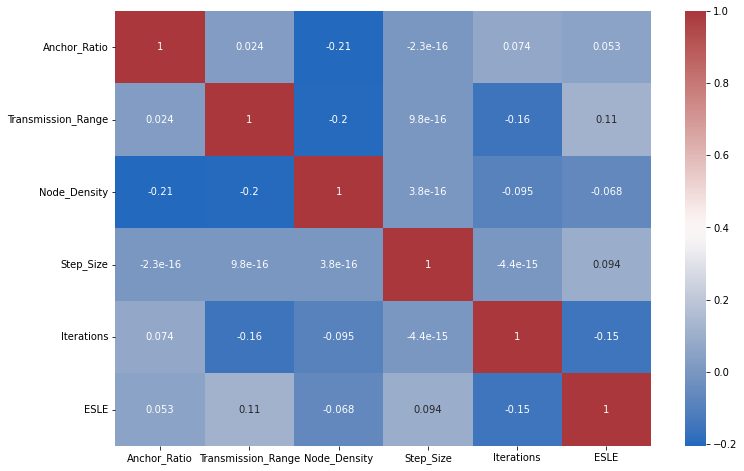

In [57]:
# correlation analysis of the dataset (Pearson's correlation coefficient)
plt.figure(figsize=(12, 8))
# with nice colours, such that 0 always corresponds to white
colour = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(data.corr(), annot=True, cmap=colour)
plt.show()

# other cmap options are: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# a colormap such that 0 always corresponds to white is 'coolwarm', 'bwr', 'seismic'

### Data Reduction

### Data transformation and data discretization

# Creating the models

#### Transform Data

In [74]:
# copy dataset data
data_copy = data_wout_outliers.copy()

# split dataset into input and output variables, y is the last column
X = data_copy.iloc[:, :-1]
y = data_copy.iloc[:, -1]

# Define seed for reproducibility
seed = 42

# assuming X and y are your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Normalize the data between 0 and 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler object to a file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)


#### Ploting data 

In [60]:
# plotting the results
def plot_results(y_test, y_pred):
    plt.scatter(y_test, y_pred, color='blue')
    plt.title('MLP regressor model')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.show()

#### Save Model


In [61]:
def save_model(model, filename):
    # save model
    pickle.dump(model, open(filename, "wb"))

def load_model(filename):
    # load model
    loaded_model = pickle.load(open(filename, "rb"))
    return loaded_model

#### Metric

In [62]:
def metric_evaluation(y_test, y_pred):
    # RMSE 
    print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    # R2 score
    print("R2 score: ", r2_score(y_test, y_pred))


### MLP 

In [77]:
# Define the model
model = MLPRegressor(activation='logistic', solver='sgd', early_stopping=True,
                     max_iter=200, validation_fraction=0.2, learning_rate='adaptive',
                     batch_size=128, n_iter_no_change=20, tol=1e-4)

# Define the grid of hyperparameters to search
parameter_space = {
    'hidden_layer_sizes': [(10,), (10,5), (10,10), (50,), (100,), (100, 5), (100, 10), (50, 50), (100, 5)],
    'learning_rate_init': [0.0001, 0.001, 0.005, 0.01, 0.1],
    'alpha': [0.0001, 0.001, 0.01]
}

# Set up the grid search 
clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5) # cv = number of folds

# Fit the model on the training data
clf.fit(X_train, y_train)

# Best parameter set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Predict on the test set using the best parameters
y_pred = clf.predict(X_test)

# Root mean squared deviation
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

save_model(clf, 'model.pickle')

Best parameters found:
 {'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.1}
-0.125 (+/-0.307) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.0001}
-0.080 (+/-0.083) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001}
-0.084 (+/-0.526) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.005}
-0.015 (+/-0.257) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01}
0.295 (+/-0.719) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.1}
-0.431 (+/-0.605) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.0001}
-0.051 (+/-0.093) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.001}
-0.046 (+/-0.076) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.005}
-0.069 (+/-0.159) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.01}
0.300 (+/-0.585)

c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [76]:
# create MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(100,), 
                     alpha=0.0001,
                     learning_rate_init=0.1,
                     activation='logistic', 
                     solver='sgd', 
                     early_stopping=True,
                     max_iter=50,
                     validation_fraction=0.2, 
                     learning_rate = 'adaptive',
                     batch_size=128,
                     n_iter_no_change=50, tol=1e-4)

rmse_mean = []
r2_mean = []

for i in range(100):

    # train the model
    model.fit(X_train, y_train)

    # predict on the test data
    y_pred = model.predict(X_test)

    # calculate the MRSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mse_mean.append(mse)
    r2_mean.append(r2_score(y_test, y_pred))
    #print(f"Mean Squared Error on Test Data: {mse}")

    #print('Coefficient of determination (regression score function): %.2f' % r2_score(y_test, y_pred))
#RMSE
print(f"RMSE on Test Data: {np.mean(np.sqrt(mse_mean))}")
print(f"R2 score on Test Data: {np.mean(r2_mean)}")
#plot_results(y_test, y_pred)


c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

RMSE on Test Data: 0.36340173404163834
R2 score on Test Data: -0.10090376106149139


c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\leo_b\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

### CNN

In [38]:
# reshape the data to 3D for CNN input
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the model
model = Sequential()
model.add(Conv1D(32, 2, activation='sigmoid', input_shape=(X_train_cnn.shape[1], 1)))
model.add(Flatten())
model.add(Dense(1))

# Compile the model
model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mse'])

mse_mean_cnn = []

for i in range(100):

    # Fit the model
    history = model.fit(X_train_cnn, 
                        y_train, 
                        validation_split=0.2, 
                        epochs=100, 
                        batch_size=128, 
                        verbose=0, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

    # Predict on the test data
    y_pred = model.predict(X_test_cnn)

    # calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    mse_mean_cnn.append(mse)
    #print(f"Mean Squared Error on Test Data: {mse}")

print(f"Mean Squared Error on Test Data: {np.mean(mse_mean_cnn)}")

"""
# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
"""

2/2 [==============================] - 0s 2ms/step
Mean Squared Error on Test Data: 0.33170198752996605


"\n# plot training and validation loss\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('Model loss')\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Validation'], loc='upper right')\nplt.show()\n"

### RNN